# EDA
Perform EDA on the dataset, clean the dataset by handling missing values, duplicates, develop new features based on the transactional data to create a customer-centric dataset, setting the foundation for customer segmentation.

## Setup and Initialization

### Importing necessary libraries

In [1]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set_theme(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

### Loading the datasets

In [4]:
customers = pd.read_csv('../datasets/Customers.csv')
products = pd.read_csv('../datasets/Products.csv')
transactions = pd.read_csv('../datasets/Transactions.csv')

## Initial Data Analysis

### Dataset Overview

#### Customers

In [5]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


Inferences:
The customers dataset contains 200 entries and 4 columns. Here is brief overview of each column:
- `CustomerID`: An object column that contains the customer ID. 
- `CustomerName`: An object column that contains the name of the customer.
- `Region`: An object column recording the region/continent where each customer resides.
- `SignupDate`:  An object column that records the date when each customer signed up.

#### Products

In [7]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


Inferences:
The dataset consists of 100 entries and 4 columns. Here is a brief overview of each column:
- `ProductID`: An object column that represents the product code for each item.
- `ProductName`: An object column that contains the name of the product.
- `Category`: An object column that contains the category of the product.
- `Price`: A float column that contains the price of a single unit of the product.

#### Transactions

In [9]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


Inferences: The dataset consists of 1000 entries and 7 columns. Heres a brief overview of each column:
- `TransactionID`: This is an object column that contains the ID for each transaction. Each TransactionID can represent multiple items purchased in a single transaction.
- `CustomerID`: An object column that contains the customerID for each transaction.
- `ProductID`: An object column that represents the product code for each item.
- `TransactionDate`: An object column that records the data and time of each transaction.
- `Quantity`: This is an integer column indicating the quantity of products purchased in each transaction.
- `TotalValue`: This is a float column representing the total monetary value of each transaction. It is computed by multiplying the quantity of products purchased by the unit price.
- `Price`: A float column representing the unit price of each product


#### Merging datasets

In [11]:
df = pd.merge(transactions, products, on='ProductID', how='left')
df = pd.merge(df, customers, on='CustomerID', how='left')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


Now, Im going to drop the Price_y column since it duplicated during merging.

In [12]:
df.drop(['Price_y'], axis=1, inplace=True)
df = df.rename(columns={'Price_x': 'UnitPrice'})
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,UnitPrice,ProductName,Category,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,Timothy Perez,Europe,2022-03-15


TransactionDate and SignupDate are present as object dtype. I will convert them to DateTime dtype.

In [13]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   UnitPrice        1000 non-null   float64       
 7   ProductName      1000 non-null   object        
 8   Category         1000 non-null   object        
 9   CustomerName     1000 non-null   object        
 10  Region           1000 non-null   object        
 11  SignupDate       1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 93.9+ KB


### Summary Statistics

In [15]:
# Summary statistics for numerical variables
df[['Quantity', 'TotalValue', 'UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1000.0,2.53700,1.117981,1.00,2.000,3.00,4.00,4.00
TotalValue,1000.0,689.99556,493.144478,16.08,295.295,588.88,1011.66,1991.04
UnitPrice,1000.0,272.55407,140.736390,16.08,147.950,299.93,404.40,497.76


In [16]:
# summary statistics for categorical values
df.describe(include='object').T

,count,unique,top,freq
TransactionID,1000,1000,T00001,1
CustomerID,1000,199,C0109,11
ProductID,1000,100,P059,19
ProductName,1000,66,ActiveWear Smartwatch,40
Category,1000,4,Books,270
CustomerName,1000,199,Abigail Jones,11
Region,1000,4,South America,304


Inference:

- `Quantity`:
    - The average quantity of products purchased in a transaction is approximately 2.53
    - The absence of outliers is indicated by no difference between the maximum and 75th percentile values
- `UnitPrice`:
    - The average unit price of the products in approximately 272.55.
    - There doesnt seem to be any outliers
- `TransactionID`:
    - There are 1000 unique transaction IDs, indicating 1000 separate transactions
- `CustomerID` & `CustomerName`:
    - There are 199 unique customerIDs, representing different customers
    - The most frequent customerID is `C0109`, appearing 11 times, that customer being `Abigail Jones`
- `ProductID`:
    - There are 100 unique product IDs representing different products
    - The most frequent productID is `P059`, appearing 19, making it the most purchased product.
- `Category`:
    - There are 4 unique categories.
- `Region`:
    - The transactions come from 4 different regions, with an even spread, but most originating from South America

## Data Cleaning and Transformation

### Handling Missing Values

In [17]:
# calculate number of missing values for each column
df.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
UnitPrice          0
ProductName        0
Category           0
CustomerName       0
Region             0
SignupDate         0
dtype: int64

There are no missing values in any column.

### Handling Duplicates

In [18]:
# finding duplicate rows
df[df.duplicated()]

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,UnitPrice,ProductName,Category,CustomerName,Region,SignupDate


There are no duplicates in the data

### Products Analysis

Lets find the number of unique product names and plot the top 10 most frequent products along with their percentage frequency:

In [19]:
# finding the number of unique products
unique_products = df['ProductName'].nunique()

# printing the number of unique procuts
print(f"The number of unique products in the dataset is: {unique_products}")

The number of unique products in the dataset is: 66


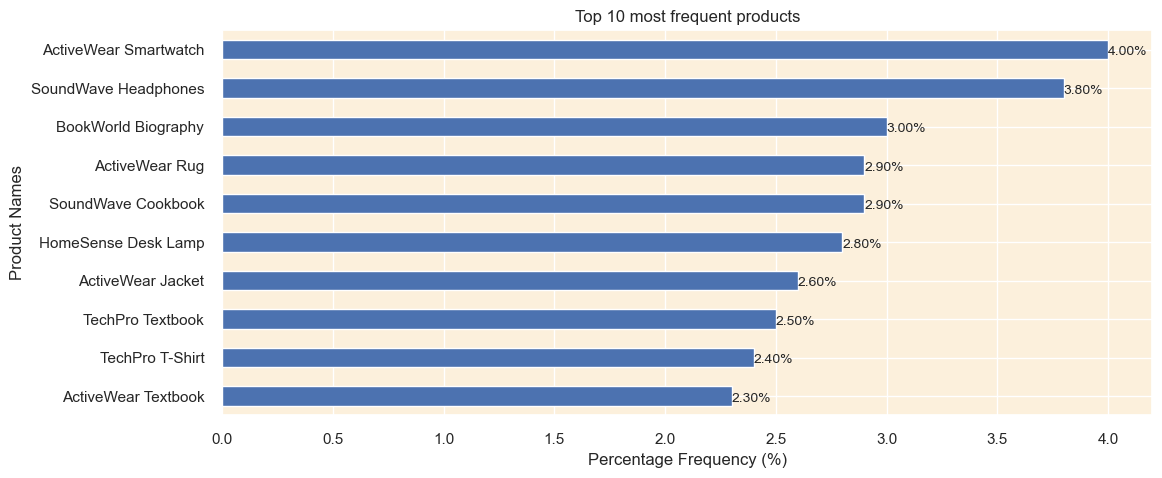

In [20]:
# finding the top 10 products
top_10_products = df['ProductName'].value_counts(normalize=True).head(10) * 100

# plotting the top 10 products
plt.figure(figsize=(12, 5))
top_10_products.plot(kind='barh')

# adding percentage frequency on the bars
for index, value in enumerate(top_10_products):
    plt.text(value, index+0.15, f"{value:.2f}%", fontsize=10)

plt.title('Top 10 most frequent products')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Product Names')
plt.gca().invert_yaxis()
plt.show()

Inference:
- `Product Variety`: The dataset contains 66 unique products by name, indicating variety in the products available. This diversity can potentially lead to identification of distinct customer clusters, with preference for different types of products.
- `Popular Items`: A closer look at the top 10 most frequent products can offer insights into the popular products or categories that are frequently purchased by customers.

In [21]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# Getting the number of rows in the dataframe
df.shape[0]

1000

## Feature Engineering

### RFM Features

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

- `Recency (R)`: This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

- `Frequency (F)`: This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

- `Monetary (M)`: This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.


#### Recency(R)

This step focuses on determining how recently a consumer completed a transaction.  This is an important part of customer segmentation because it helps identify customers' levels of engagement.  Here, I will define the following feature:
- `Days Since Last Purchase`: This feature indicates how many days have gone since the customer's last purchase.  A smaller number shows that the consumer made a recent purchase, meaning that they are more engaged with the company, whereas a greater value may indicate a lapse or decreased involvement.  Businesses can modify their marketing efforts to re-engage customers who haven't made a purchase in a while, potentially enhancing customer retention and loyalty.

In [22]:
# From TransactionDate extract only the date
df['TransactionDay'] = df['TransactionDate'].dt.date

In [23]:
# find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['TransactionDay'].max().reset_index()

# find the most recent date in the entire dataset
most_recent_date = df['TransactionDay'].max()

# Convert TransactionDay to datetime type before subtraction
customer_data['TransactionDay'] = pd.to_datetime(customer_data['TransactionDay'])
most_recent_date = pd.to_datetime(most_recent_date)

In [24]:
# calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['TransactionDay']).dt.days

# remove the TransactionDay column
customer_data.drop(columns=['TransactionDay'], inplace=True)

In [25]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,C0001,56
1,C0002,25
2,C0003,126
3,C0004,5
4,C0005,54


#### Frequency (F)

In this stage, I'll design two features that quantify a customer's interaction with the retailer:

- `Total Transactions`: This feature shows the total number of transactions completed by a customer.  It helps to understand a customer's level of engagement with the retailer.

- `Total Products Purchased`: This feature displays the total number of products purchased by a customer across all transactions.  It provides information about the customer's purchasing habits based on the number of items purchased.

 These qualities will be critical in segmenting customers based on their purchasing frequency, which is an important factor in identifying client categories for targeted marketing and tailored suggestions.


In [26]:
# calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
total_transactions.rename(columns={
    "TransactionID": 'Total_Transactions'
}, inplace=True) 

# calulate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={
    'Quantity': 'Total_Products_Purchased'
}, inplace=True)

In [27]:
# merge the new features into customer_data
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,C0001,56,5,12
1,C0002,25,4,10
2,C0003,126,4,14
3,C0004,5,8,23
4,C0005,54,3,7


#### Monetory (M)

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:
- `Total Spend`: This feature shows the total amount spent by each customer.  It is determined as the total of the product of UnitPrice and Quantity for all transactions completed by a customer.  This feature is critical since it assists in determining the overall revenue generated by each customer, which is a clear indication of a customer's value to the firm.

- `Average Transaction Value`: This characteristic is determined by dividing the Total Spend by the Total Transactions for each client.  It represents the average value of a transaction completed by a customer.  This measure can help adjust marketing tactics and offers to different customer segments depending on their average spending behaviors.



In [28]:
# total spend by each customer
total_spend = df.groupby('CustomerID')['TotalValue'].sum().reset_index()

# calculate the average transaction value for each customer
average_transaction_value = pd.merge(total_spend, total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['TotalValue']/ average_transaction_value['Total_Transactions']

In [29]:
# merge the new features into customer_data
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.rename(columns={
    'TotalValue': 'Total_Spend'
}, inplace=True)

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,C0001,56,5,12,3354.52,670.904
1,C0002,25,4,10,1862.74,465.685
2,C0003,126,4,14,2725.38,681.345
3,C0004,5,8,23,5354.88,669.360
4,C0005,54,3,7,2034.24,678.080


### Product Diversity



In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

- `Unique Products Purchased`: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [30]:
# calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['ProductID'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProductID': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,56,5,12,3354.52,670.904,5
1,C0002,25,4,10,1862.74,465.685,4
2,C0003,126,4,14,2725.38,681.345,4
3,C0004,5,8,23,5354.88,669.360,8
4,C0005,54,3,7,2034.24,678.080,3


### Behvioral Features

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

- `Average Days Between Purchases`: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

- `Favorite Shopping Day`: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

- `Favorite Shopping Hour`: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments

In [31]:
# Extract day of the week and hour from TransactionDate
df['Day_Of_Week'] = df['TransactionDate'].dt.dayofweek
df['Hour'] = df['TransactionDate'].dt.hour

In [32]:
# calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['TransactionDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={
    'TransactionDay': 'Average_Days_Between_Purchases'
}, inplace=True)

In [33]:
# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

In [34]:
# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

In [35]:
# merge the new features into customer_data
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,C0001,56,5,12,3354.52,670.904,5,72.000000,1,3
1,C0002,25,4,10,1862.74,465.685,4,48.000000,1,1
2,C0003,126,4,14,2725.38,681.345,4,27.333333,6,2
3,C0004,5,8,23,5354.88,669.360,8,22.428571,0,10
4,C0005,54,3,7,2034.24,678.080,3,91.500000,0,0


### Geographical Features

In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:

- `Region`: This feature identifies the Region where each customer is located. Including the region data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning.

In [36]:
# one hot encode the 'Region' feature from the customers dataframe
region_encoded = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'], prefix='Region', dtype=int)

# merge with customer_data on the 'CustomerID'
customer_data = pd.merge(customer_data, region_encoded, on='CustomerID', how='left')

# display the updated customer_data
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,56,5,12,3354.52,670.904,5,72.000000,1,3,0,0,0,1
1,C0002,25,4,10,1862.74,465.685,4,48.000000,1,1,1,0,0,0
2,C0003,126,4,14,2725.38,681.345,4,27.333333,6,2,0,0,0,1
3,C0004,5,8,23,5354.88,669.360,8,22.428571,0,10,0,0,0,1
4,C0005,54,3,7,2034.24,678.080,3,91.500000,0,0,1,0,0,0


### Seasonality & Trends

In this stage, I'll look at seasonality and trends in client purchase behaviors, which can provide significant data for adjusting marketing campaigns and improving customer happiness.  Here are the features I want to introduce:

- `Monthly_Spending_Mean`: This is the average amount a customer spends per month. A larger mean indicates a higher-spending customer, possibly interested in premium products, whilst a lower mean may indicate a more budget-conscious customer.
- `Monthly_Spending_Std`:  This feature shows the variation in a customer's monthly spending.  A greater score indicates that the customer's expenditure varies dramatically month to month, maybe indicating sporadic huge purchases.  In comparison, a lower number indicates more solid and consistent spending patterns.
- `Spending_Trend`: This indicates the trend in a customer's spending over time, determined as the slope of the linear trend line fitted to their spending information.  A positive score implies an upward trend in spending, maybe indicating increased loyalty or satisfaction.  A negative trend, on the other hand, may indicate declining interest or satisfaction, emphasizing the need for re-engagement strategies.  A near-zero result indicates consistent spending patterns.

In [37]:
# Extract month and year from InvoiceDate
df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['TotalValue'].sum().reset_index()

In [38]:
# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['TotalValue'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

In [39]:
# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['TotalValue'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'TotalValue': 'Spending_Trend'}, inplace=True)

In [40]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Region_Asia,Region_Europe,Region_North America,Region_South America,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,C0001,56,5,12,3354.52,670.904,5,72.000000,1,3,0,0,0,1,670.904000,456.643861,217.032000
1,C0002,25,4,10,1862.74,465.685,4,48.000000,1,1,1,0,0,0,465.685000,219.519169,-147.630000
2,C0003,126,4,14,2725.38,681.345,4,27.333333,6,2,0,0,0,1,908.460000,685.907372,631.420000
3,C0004,5,8,23,5354.88,669.360,8,22.428571,0,10,0,0,0,1,764.982857,489.591411,70.506429
4,C0005,54,3,7,2034.24,678.080,3,91.500000,0,0,1,0,0,0,678.080000,310.820746,-270.990000


In [41]:
# TODO: VISUALIZATIONS

Now that we have created a dataset that focuses on the customers, we can save it and use in the next steps of our project.

In [42]:
customer_data.to_csv('../datasets/customer_data.csv', index=False)
print("Customer data has been saved as 'customer_data.csv'")

Customer data has been saved as 'customer_data.csv'
